In [1]:
from datetime import datetime, timedelta
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt


from dotenv import load_dotenv
import os

load_dotenv()


True

In [2]:
TOKEN = os.getenv("TOKEN")
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - relativedelta(years=3)
SHORT_WINDOW_SIZE = 50
LONG_WINDOW_SIZE = 200
LKOH = "BBG004731032"
data_candle = []
initial_capital = 50_000


In [3]:
with Client(TOKEN) as c:
    for candle in c.get_all_candles(
        instrument_id=LKOH,
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_candle.append({
            'date': candle.time.date(),
            'price': candle.close.units + candle.close.nano / 1e9,
        })

raw_data = pd.DataFrame(data_candle)
raw_data.set_index('date', inplace=True)
raw_data.sort_index()


,price
date,
2022-12-21,4040.5
2022-12-22,4027.5
2022-12-23,4010.5
2022-12-26,4010.0
2022-12-27,4028.5
...,...
2025-12-17,5730.5
2025-12-18,5888.0
2025-12-19,5897.5


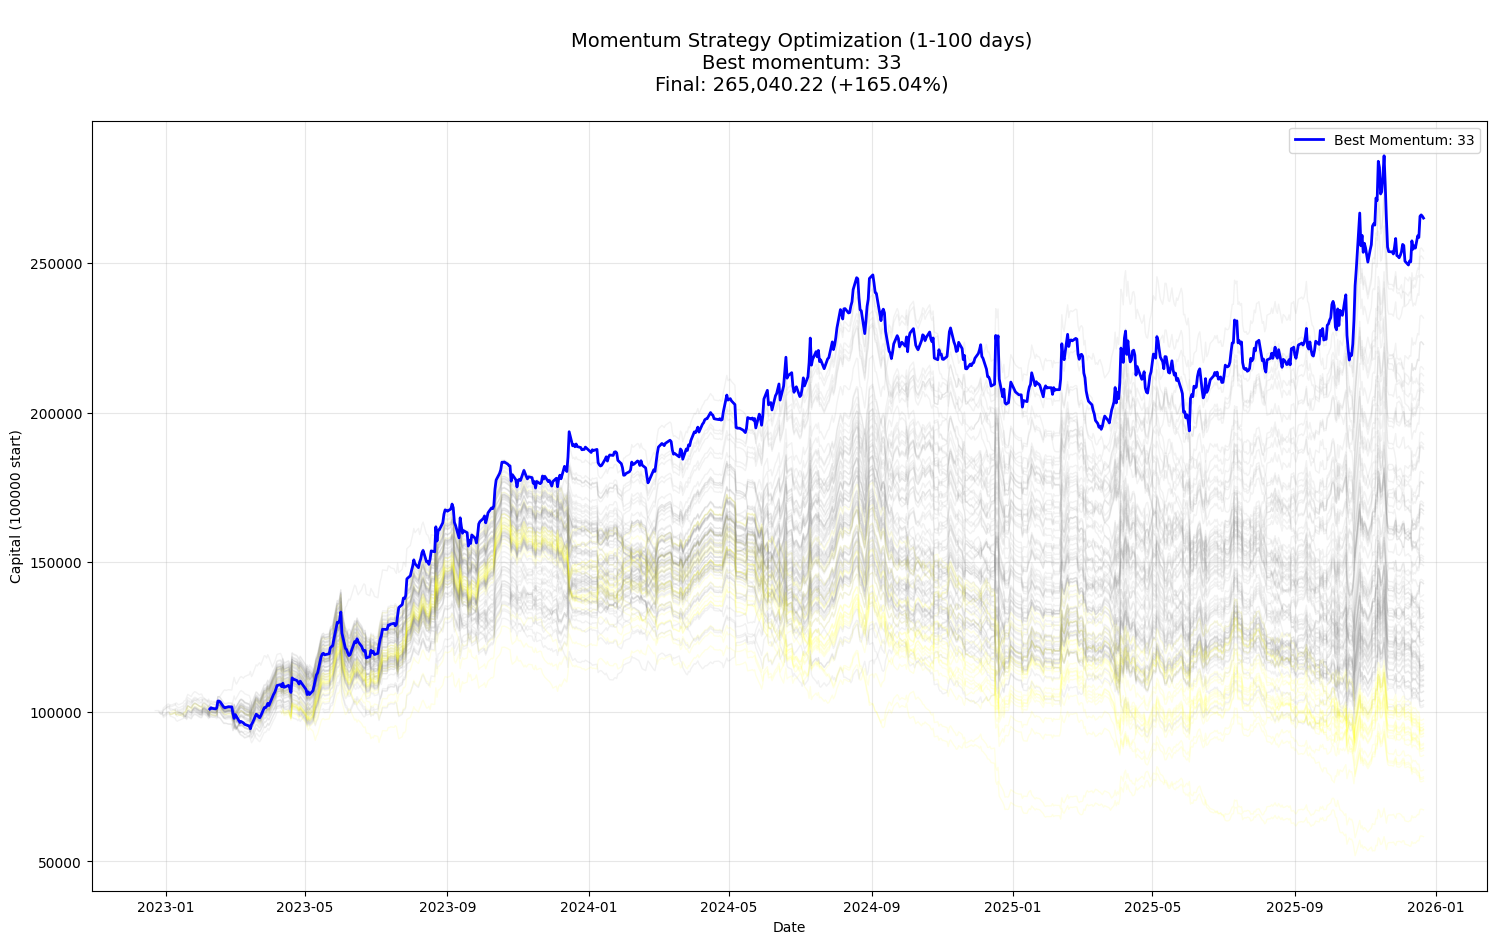

In [21]:
result = {}
deposit = 100_000
all_strategies = pd.DataFrame(index=raw_data.copy().index) # Сюда будем собирать кривые доходности
plt.figure(figsize=(18, 10), dpi=100)
days_range = 100

for momentum in range(1, days_range):
    df = raw_data.copy()
    # делим для того что бы понять отношение цены сегодняшей к прошлой дате. Если 1 то ничего не поменялось
    # если меньше 1 то цена упала
    # если больше 1 то цена выросла
    # далее считаем от этого натуральный логафрим. Так удобнее считать,
    # т.к. проценты нельзя складывать, а логарифмы можно и они будут давать верный результат
    df["return"] = np.log(raw_data["price"] / df["price"].shift(1))
    # удаляем первую строку по сути
    df.dropna(inplace=True)
    # тут берём скользящую среднюю с фиксированным окном
    # и сразу навешиваем флаг что бы понимать куда идём
    df["position"] = np.sign(df["return"].rolling(momentum).mean())
    df['strategy'] = df['position'].shift(1) * df['return']
    df.dropna(inplace=True)

    trades = df['position'].diff().fillna(0) != 0
    # вычетаем комиссию
    df.loc[trades, 'strategy'] -= 0.0004
    df['creturns'] = deposit * df['return'].cumsum().apply(np.exp)
    df['cstrategy'] = deposit * df['strategy'].cumsum().apply(np.exp)

    # absolute performance of the strategy
    aperf = df['cstrategy'].iloc[-1]
    # out-/underperformance of strategy
    operf = aperf - df['creturns'].iloc[-1]
    result[momentum] = round(aperf, 2), round(operf, 2)

    final_value = df['cstrategy'].iloc[-1]

    plt.plot(df['cstrategy'], color='grey' if final_value > deposit else 'yellow', alpha=0.1, linewidth=1)

    # сохраняем данные для выделения лучшей стратегии
    all_strategies[momentum] = df['cstrategy']

ideal_momentum = max(result, key=result.get)
max_performance = result[ideal_momentum][0]
total_return_pct = ((max_performance - deposit) / deposit) * 100

text = f"""
    Momentum Strategy Optimization (1-{days_range} days)
    Best momentum: {ideal_momentum}
    Final: {max_performance:,.2f} ({total_return_pct:+.2f}%)
"""

plt.plot(all_strategies[ideal_momentum], color='blue', linewidth=2, label=f'Best Momentum: {ideal_momentum}')
plt.title(text, fontsize=14)
plt.xlabel('Date')
plt.ylabel(f'Capital ({deposit} start)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('linear')
plt.show()
